<div align='center'><font size="5" color="#00000"><center><h1 style="text-transform: uppercase; text-shadow: 1px 1px;"> PySaDML </h1></center></font></div> <br>
<div align='center'><font size="4" color="#00000"><center><h1 style="text-transform: uppercase; text-shadow: 1px 1px;"> CNN Model - MFCC SPECTOGRAM. </h1></center></font></div>

<div align='center'><font size="2" color="#00000"><center><h1 style="text-transform: uppercase; text-shadow: 1px 1px;"> Détection de son anormal dans les pièces industrielles </h1></center></font></div>
<br>

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# =============================================================================
# Created By  : Mike G
# Created Date: Thursday Nov 25 15:00:00 UTC 2021
# =============================================================================
# Required libraries
import pandas as pd
import numpy as np

from datetime import datetime
from include import common, models

from pathlib import Path

from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder

# Make the creating of our model a little easier
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Dropout, Dense, Flatten, Conv2D, MaxPooling2D, Activation, AveragePooling2D
from tensorflow.keras import backend as K

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

import warnings
warnings.filterwarnings('ignore')

#show pandas version
pd.__version__

'1.3.4'

In [2]:
# l'extension du fichier de données a importer.
EXT = '.csv'

# Le répertoire racine des données audio dev_data et eval_data
DATASET_ROOT = './../data'

# Les dossiers dans lesquels se trouvent les audios.
AUDIO_SUBFOLDER = '/dev_data'

# Les dossiers dans lesquels se trouvent les fichiers numpy.
NUMPY_SUBFOLDER = '/numpy_files'

# Les dossiers dans lesquels se trouvent les models.
MODEL_SUBFOLDER = '/models'

# Les dossiers racine dans lesquels se trouvent les spectrogrammes.
IMAGE_ROOT = './../images'

TRAIN_SUBFOLDER = '/train'

TEST_SUBFOLDER = '/test'


DATASET_AUDIO_PATH = Path(DATASET_ROOT + AUDIO_SUBFOLDER)

DATASET_NUMPY_PATH = Path(DATASET_ROOT + NUMPY_SUBFOLDER)

MODELS_PATH    = Path(DATASET_ROOT + MODEL_SUBFOLDER)

# Setup the train and test directories
train_dir = Path(IMAGE_ROOT + TRAIN_SUBFOLDER)
test_dir =  Path(IMAGE_ROOT + TEST_SUBFOLDER)

# Si le dossier dev_data n'existe pas, le créer, sinon ne rien faire.
Path(DATASET_AUDIO_PATH).mkdir(parents=True, exist_ok=True)

## Préparation des données

In [3]:
# Define hyper-parameters
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-05
MOMENTUM = 0.9

BETA1=0.9
BETA2=0.999
EPSILON=1e-08

IMAGE_SHAPE  = 64
CHANNELS = 3

INPUT_SHAPE = (465, 302, 3)

In [4]:
# Organize data into train, test dirs
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

# Create ImageDataGenerator training instance without data augmentation
train_datagen = ImageDataGenerator(rescale=1./255) 

# Create ImageDataGenerator test instance without data augmentation
test_datagen = ImageDataGenerator(rescale=1./255)

In [5]:
# Create non-augmented data batches
print("Non-augmented training images:")
train_data = train_datagen.flow_from_directory(train_dir,
                                               target_size=(465, 302),
                                               batch_size=BATCH_SIZE,
                                               class_mode='categorical',
                                               seed=42,
                                               shuffle=False)


print("Unchanged test images:")
test_data = test_datagen.flow_from_directory(test_dir,
                                             target_size=(465, 302),
                                             batch_size=BATCH_SIZE,
                                             seed=42,
                                             class_mode='categorical',
                                             shuffle=False)

Non-augmented training images:
Found 20119 images belonging to 6 classes.
Unchanged test images:
Found 10868 images belonging to 6 classes.


In [6]:
CLASS_LABELS = list(test_data.class_indices.keys())
NUM_LABELS = len(CLASS_LABELS)

# Get data batch samples
X_train, y_train = train_data.next()
X_test, y_test = test_data.next()


## Visualisation des images

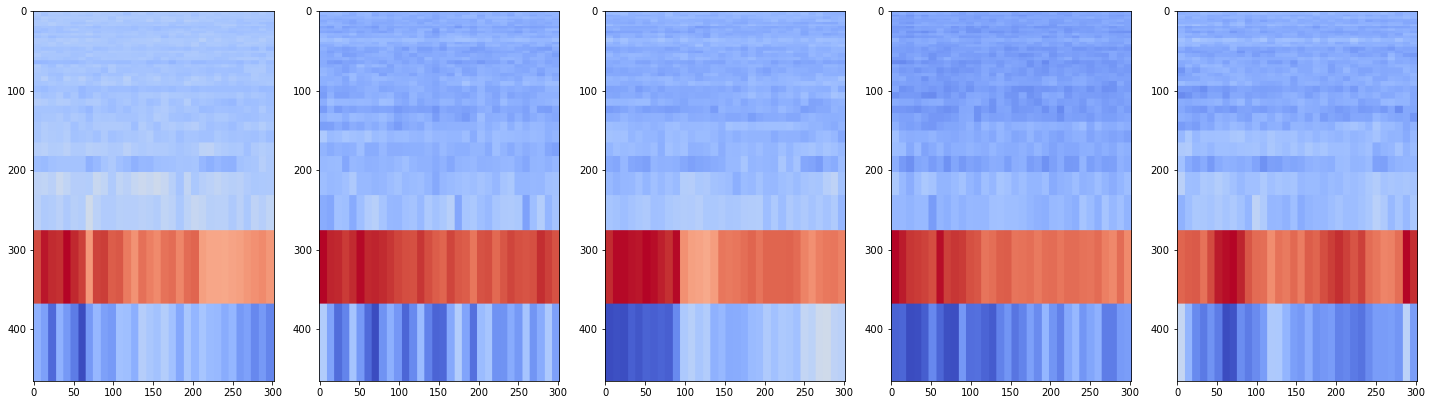

In [7]:
# show 5 images
origin_image = next(train_data)[0][:5]
fig, axes = plt.subplots(1, 5, figsize=(20, 20))
for img, ax in zip(origin_image, axes.flatten()):
    ax.imshow(img)
plt.tight_layout()
plt.show()

In [8]:
model = Sequential()

model.add(Conv2D(32, (3, 3), strides=(2, 2), padding="same", input_shape=INPUT_SHAPE))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

#2nd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

#3rd hidden layer
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

#4th hidden layer
model.add(Conv2D(64, (3, 3), padding="valid"))
model.add(AveragePooling2D((2, 2), strides=(2,2)))
model.add(Activation('relu'))

#Flatten
model.add(Flatten())
model.add(Dropout(rate=0.5))

#Add fully connected layer.
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(rate=0.5))

#Output layer
model.add(Dense(NUM_LABELS))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 233, 151, 32)      896       
                                                                 
 average_pooling2d (AverageP  (None, 116, 75, 32)      0         
 ooling2D)                                                       
                                                                 
 activation (Activation)     (None, 116, 75, 32)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 116, 75, 64)       18496     
                                                                 
 average_pooling2d_1 (Averag  (None, 58, 37, 64)       0         
 ePooling2D)                                                     
                                                                 
 activation_1 (Activation)   (None, 58, 37, 64)        0

In [9]:
# Compile model
OPTIMIZER = Adam(learning_rate=LEARNING_RATE, beta_1=BETA1, beta_2=BETA2, epsilon=EPSILON)

LOSS = 'categorical_crossentropy'
METRICS = 'accuracy'

In [10]:
model.compile(
    loss=LOSS, 
    optimizer=OPTIMIZER, 
    metrics=[METRICS])

#### Fit du modèle

In [11]:
start = datetime.now()
np.random.seed(23456)
K.clear_session()
model_file = 'cnn_mfcc_image.hdf5'
model_path = Path(MODELS_PATH, model_file)

# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, save_best_only=True)

# Save learning rate
reduce_lr = ReduceLROnPlateau(patience=3, cooldown=5, min_lr=1e-5)

# interrupt the training process when the validation loss is no longer improving
early_stop = EarlyStopping(min_delta=1e-6, patience=15, verbose=1, restore_best_weights=True)


history = model.fit(train_data, 
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=len(test_data),
                    callbacks=[checkpointer, reduce_lr, early_stop])

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
629/629 [==============================] - 428s 679ms/step - loss: 1.6760 - accuracy: 0.2956 - val_loss: 1.5039 - val_accuracy: 0.3940 - lr: 1.0000e-05
Epoch 2/50
629/629 [==============================] - 420s 667ms/step - loss: 1.3233 - accuracy: 0.4592 - val_loss: 1.2116 - val_accuracy: 0.5451 - lr: 1.0000e-05
Epoch 3/50
629/629 [==============================] - 458s 729ms/step - loss: 1.2136 - accuracy: 0.5003 - val_loss: 1.1081 - val_accuracy: 0.5583 - lr: 1.0000e-05
Epoch 4/50
629/629 [==============================] - 417s 663ms/step - loss: 1.1679 - accuracy: 0.5201 - val_loss: 1.0743 - val_accuracy: 0.5840 - lr: 1.0000e-05
Epoch 5/50
629/629 [==============================] - 418s 664ms/step - loss: 1.1258 - accuracy: 0.5412 - val_loss: 1.0256 - val_accuracy: 0.6206 - lr: 1.0000e-05
Epoch 6/50
629/629 [==============================] - 669s 1s/step - loss: 1.0933 - accuracy: 0.5595 - val_loss: 0.9784 - val_accuracy: 0.6413 - lr: 1.0000e-05
Epoch 7/50
629/629 [=====

#### Evaluation du modèle

In [12]:
# Load best saved model
model = load_model(model_path)

In [13]:
#Model Evaluation
models.model_metric_report(model, test_data=test_data, train_data=train_data)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.6951        73.03%
Test:             0.6618        77.43%
--------------------------------------

Error rate         4.79% 


#### Graphiques

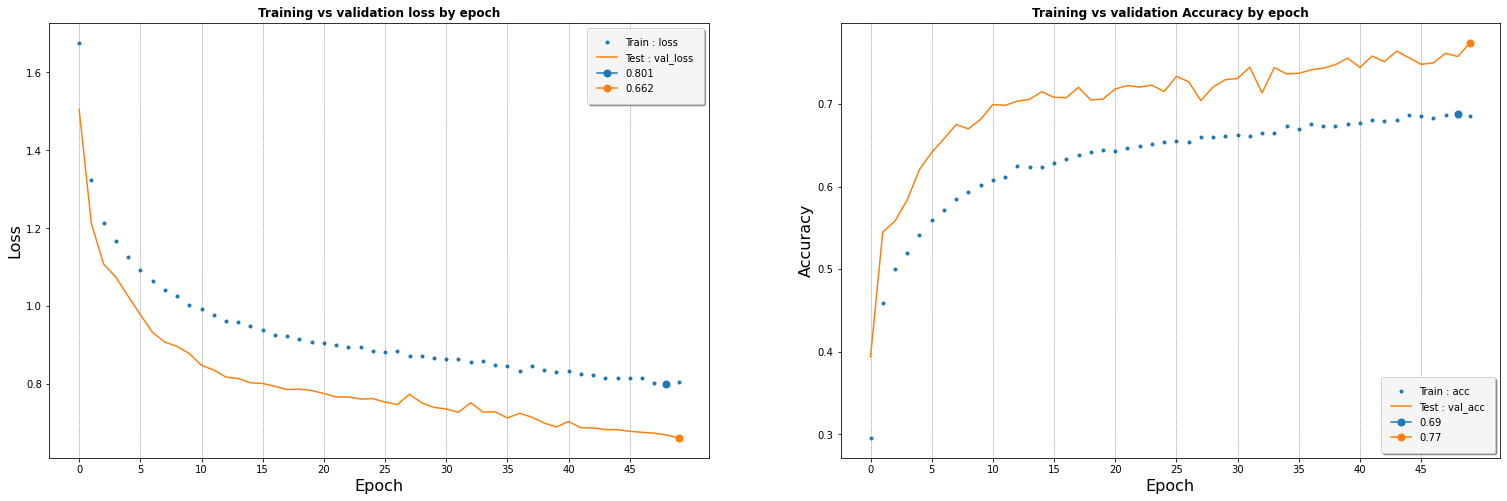

In [14]:
models.plot_model_history(history, ylabel_metric='Accuracy', metrics=METRICS, size=(26,8))

#### Prédictions

In [15]:
# Predict probabilities for test set
test_data.reset()
predictions = model.predict_generator(test_data)

# Get predicted labels
predictedClass = predictions.argmax(axis = 1)
trueClass = test_data.classes[test_data.index_array]

#### Confusion matrix

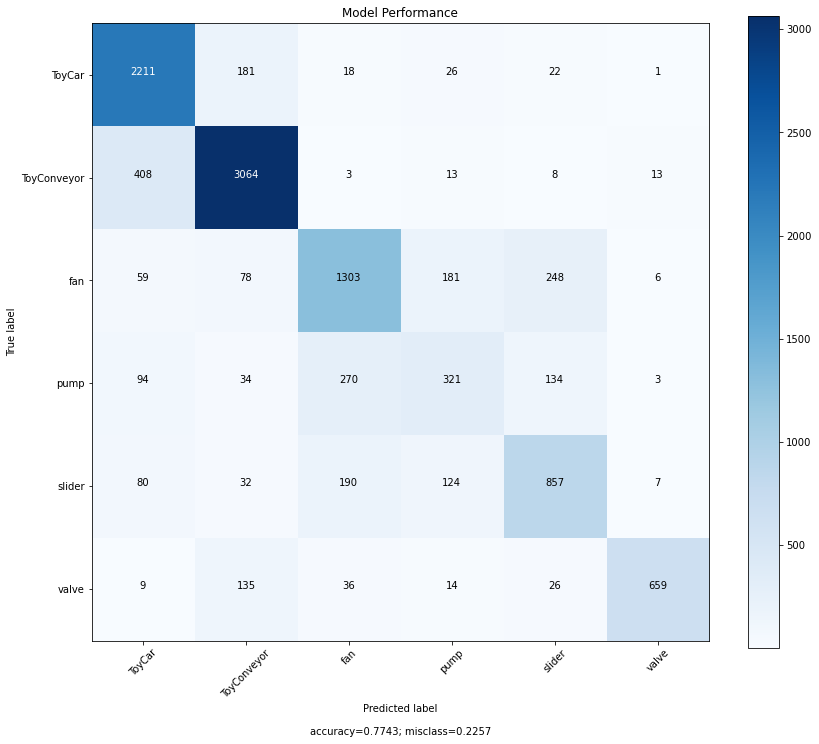

In [16]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

models.plot_confusion_matrix(y_true=trueClass, 
                             y_pred=predictedClass, 
                             class_label=CLASS_LABELS, 
                             title="Model Performance",
                             size=(12,10))

#### Tableau de précision

In [17]:
models.target_metric_report(trueClass, predictedClass, CLASS_LABELS)

,CLASS,ACCURACY
0,ToyCar,89.91%
1,ToyConveyor,87.32%
5,valve,74.97%
2,fan,69.49%
4,slider,66.43%
3,pump,37.50%


#### Performance de classification : scores de Presicion, Recall et F1

In [18]:
print(classification_report(trueClass, predictedClass, target_names=CLASS_LABELS))

              precision    recall  f1-score   support

      ToyCar       0.77      0.90      0.83      2459
 ToyConveyor       0.87      0.87      0.87      3509
         fan       0.72      0.69      0.71      1875
        pump       0.47      0.38      0.42       856
      slider       0.66      0.66      0.66      1290
       valve       0.96      0.75      0.84       879

    accuracy                           0.77     10868
   macro avg       0.74      0.71      0.72     10868
weighted avg       0.77      0.77      0.77     10868



#### Prédiction du modèle

In [21]:
def load_and_prep_image(filename, img_shape=(224,224), channels=3):
    img = tf.io.read_file(filename)
    
    img = tf.image.decode_image(img, channels=channels)

    img = tf.image.resize(img, size = img_shape)

    img = img/255.
    return img


def pred_and_plot_picture(model, filename, class_names, img_shape=(224,224), channels=3):
    img = load_and_prep_image(filename, img_shape=img_shape, channels=channels)

    pred = model.predict(tf.expand_dims(img, axis=0))

    if len(pred[0]) > 1:
        pred_class = class_names[pred.argmax()]
    else:
        pred_class = class_names[int(tf.round(pred)[0][0])]

    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

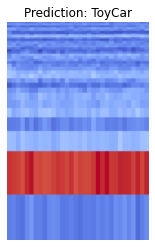

In [25]:
# Test our model on a custom image
filename="./../images/test/fan/anomaly_id_00_00000014_mfcc.png"
pred_and_plot_picture(model, filename, CLASS_LABELS, img_shape=(465,302))

In [45]:
y_test_condition = np.load(Path(DATASET_NUMPY_PATH, "test_labels_status.npy"))
df_pred_cond = pd.DataFrame(np.vstack((trueClass, y_test_condition, trueClass, predictedClass))).T
df_pred_cond.columns = ['label', 'condition', 'machine_type', 'Predict_type']
df_pred_cond.loc[df_pred_cond['machine_type'] == df_pred_cond['Predict_type'], 'Predict_condition'] = 'normal'  
df_pred_cond.loc[df_pred_cond['machine_type'] != df_pred_cond['Predict_type'], 'Predict_condition'] = 'anomaly'
pd.crosstab(df_pred_cond.condition, df_pred_cond.Predict_condition, rownames=['Classe réelle'], colnames=['Classe prédite'])

Classe prédite,anomaly,normal
Classe réelle,,
anomaly,1217,4252
normal,1236,4163


In [50]:
pd.crosstab(index=[df_pred_cond.label.map(lambda x: CLASS_LABELS[int(x)]), df_pred_cond.condition], columns=df_pred_cond.Predict_condition)

Predict_condition      anomaly  normal
label       condition                 
ToyCar      anomaly        121    1130
            normal         127    1081
ToyConveyor anomaly        233    1546
            normal         212    1518
fan         anomaly        283     678
            normal         289     625
pump        anomaly        255     155
            normal         280     166
slider      anomaly        217     429
            normal         216     428
valve       anomaly        108     314
            normal         112     345